In [ ]:
# 1. Imports

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score
)

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt




In [ ]:
# 2. Load and prepare the churn data

# Make sure `Churn_Modelling.csv` is in the same folder as this notebook
df = pd.read_csv("Churn_Modelling.csv")

print("Shape:", df.shape)
display(df.head())

# Target column
target_col = "Exited"

# Features: drop ID-like columns and target
X = df.drop(columns=["RowNumber", "CustomerId", "Surname", target_col])
y = df[target_col]

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Shape: (5000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Numeric features: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Categorical features: ['Geography', 'Gender']


In [ ]:
X_train.shape, y_train.shape

((4000, 10), (4000,))

In [ ]:
# 3. Build pipeline and train Logistic Regression

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

log_reg = LogisticRegression(max_iter=1000)

clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", log_reg)
    ]
)

clf.fit(X_train, y_train)
print("Logistic Regression model trained.")


Logistic Regression model trained.


In [ ]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Apply preprocessing to X_train
X_train_processed = preprocessor.fit_transform(X_train)

model = LogisticRegression(max_iter=1000) # Added max_iter for consistency
model.fit(X_train_processed, y_train)
print("Logistic Regression model (standalone) trained.")

Logistic Regression model (standalone) trained.


In [ ]:
# Get the weights
weights = model.coef_

print(weights)

[[-0.03960017  0.76136768 -0.04267357  0.12429419 -0.04590845 -0.03771372
  -0.56722632  0.05182867  0.69271239 -0.0768079  -0.57713588]]


In [ ]:
# Preprocess X_test and X_train using the same preprocessor used for training
X_test_processed = preprocessor.transform(X_test)
X_train_processed_for_prediction = preprocessor.transform(X_train)

# Make predictions on the test set
y_pred = model.predict(X_test_processed)

# Make predictions on the train set
y_pred_train = model.predict(X_train_processed_for_prediction)

# Evaluate the accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy_train}")

# Evaluate the accuracy
accuracy_test = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy_test}")

Train Accuracy: 0.80675
Test Accuracy: 0.816


In [ ]:
X_test.iloc[[10]]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
332,663,Germany,Male,44,2,117028.6,2,0,1,144680.18


In [ ]:
prediction = clf.predict(X_test.iloc[[10]])

print(prediction)

[0]


In [ ]:
# Get the probabilities for the first row of X_test
probabilities = clf.predict_proba(X_test.iloc[[1]])

print(probabilities)

[[0.83270004 0.16729996]]


In [ ]:
thresholds = [0.3, 0.5, 0.7]  # Example thresholds

for threshold in thresholds:
    # Get predicted probabilities
    y_pred_prob = clf.predict_proba(X_test)[:, 1]  # Probability of positive class

    # Apply threshold to get binary predictions
    y_pred = (y_pred_prob >= threshold).astype(int)

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print results
    print(f"--- Threshold: {threshold} ---")
    print("True Positives:", tp)
    print("False Positives:", fp)
    print("True Negatives:", tn)
    print("False Negatives:", fn)
    print("Accuracy:", accuracy)
    print("-------------------------\n")

--- Threshold: 0.3 ---
True Positives: 116
False Positives: 120
True Negatives: 671
False Negatives: 93
Accuracy: 0.787
-------------------------

--- Threshold: 0.5 ---
True Positives: 49
False Positives: 24
True Negatives: 767
False Negatives: 160
Accuracy: 0.816
-------------------------

--- Threshold: 0.7 ---
True Positives: 11
False Positives: 2
True Negatives: 789
False Negatives: 198
Accuracy: 0.8
-------------------------



In [ ]:
# 4. Predict the class label and probability for a new sample

# Example customer – adjust values as you like
new_customer = {
    "CreditScore": 650,
    "Geography": "France",
    "Gender": "Female",
    "Age": 40,
    "Tenure": 5,
    "Balance": 60000.0,
    "NumOfProducts": 2,
    "HasCrCard": 1,
    "IsActiveMember": 1,
    "EstimatedSalary": 80000.0,
}

new_customer_df = pd.DataFrame([new_customer])
display(new_customer_df)

# Class label prediction
new_label = clf.predict(new_customer_df)[0]
# Probability of churn (class 1)
new_proba = clf.predict_proba(new_customer_df)[:, 1][0]

print(f"Predicted class label for new customer: {new_label}")
print(f"Predicted probability of churn: {new_proba:.3f}")


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,650,France,Female,40,5,60000.0,2,1,1,80000.0


Predicted class label for new customer: 0
Predicted probability of churn: 0.115


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,threshold,accuracy,precision,recall,f1
0,0.1,0.455,0.267313,0.923445,0.414608
1,0.2,0.696,0.381546,0.732057,0.501639
2,0.3,0.787,0.491525,0.555024,0.521348
3,0.4,0.815,0.588235,0.382775,0.463768
4,0.5,0.816,0.671233,0.234450,0.347518
5,0.6,0.816,0.820513,0.153110,0.258065
6,0.7,0.800,0.846154,0.052632,0.099099
7,0.8,0.793,1.000000,0.009569,0.018957
8,0.9,0.791,0.000000,0.000000,0.000000


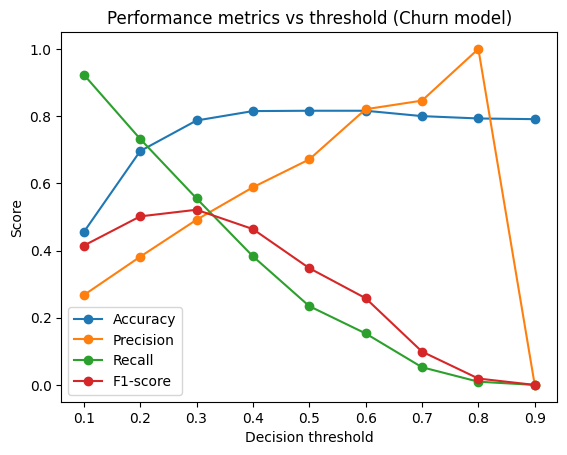

In [ ]:
# 5. Predict probabilities on the test set and evaluate at different thresholds

# Probability that each test sample churns (class 1)
y_proba = clf.predict_proba(X_test)[:, 1]

# Define thresholds to evaluate
thresholds = np.linspace(0.1, 0.9, 9)

records = []
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    acc = accuracy_score(y_test, y_pred_t)
    prec = precision_score(y_test, y_pred_t)
    rec = recall_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)
    records.append({
        "threshold": t,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    })

metrics_df = pd.DataFrame(records)
display(metrics_df)

# Plot metrics vs threshold
plt.figure()
plt.plot(metrics_df["threshold"], metrics_df["accuracy"], marker="o", label="Accuracy")
plt.plot(metrics_df["threshold"], metrics_df["precision"], marker="o", label="Precision")
plt.plot(metrics_df["threshold"], metrics_df["recall"], marker="o", label="Recall")
plt.plot(metrics_df["threshold"], metrics_df["f1"], marker="o", label="F1-score")
plt.xlabel("Decision threshold")
plt.ylabel("Score")
plt.title("Performance metrics vs threshold (Churn model)")
plt.legend()
plt.show()


Confusion matrix (threshold = 0.5):
[[767  24]
 [160  49]]


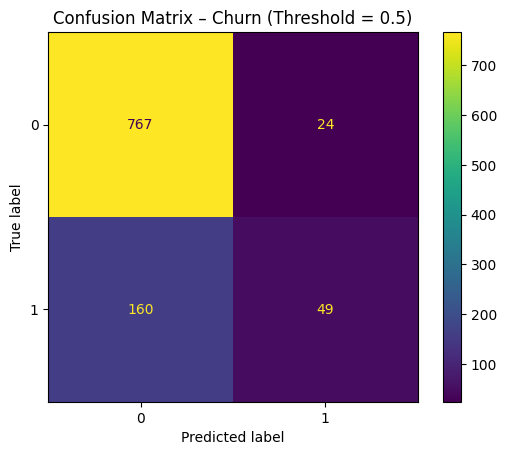

Accuracy at threshold 0.5: 0.816


In [ ]:
# 6. Confusion matrix at default threshold = 0.5

from sklearn.metrics import ConfusionMatrixDisplay

y_pred_default = (y_proba >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_default)
print("Confusion matrix (threshold = 0.5):")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix – Churn (Threshold = 0.5)")
plt.show()

acc_default = accuracy_score(y_test, y_pred_default)
print(f"Accuracy at threshold 0.5: {acc_default:.3f}")


AUC (Area Under ROC Curve): 0.783


,FPR,TPR,Threshold
0,0.000000,0.000000,inf
1,0.000000,0.004785,0.816790
2,0.000000,0.028708,0.768258
3,0.001264,0.028708,0.752102
4,0.001264,0.052632,0.702823


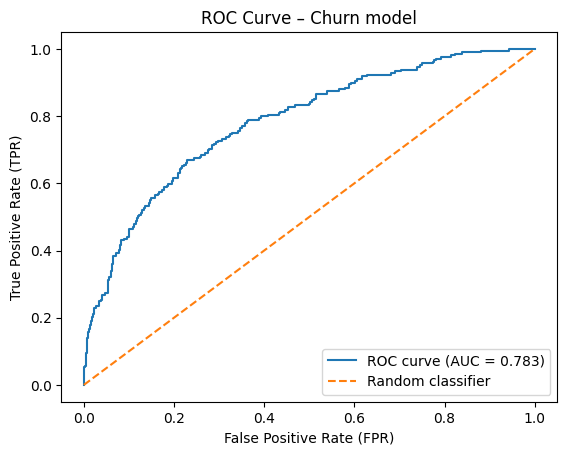

In [ ]:
# 7. ROC curve: FPR, TPR, thresholds and AUC

fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
auc_value = roc_auc_score(y_test, y_proba)

print(f"AUC (Area Under ROC Curve): {auc_value:.3f}")

roc_table = pd.DataFrame({
    "FPR": fpr,
    "TPR": tpr,
    "Threshold": roc_thresholds
})
display(roc_table.head())

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_value:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve – Churn model")
plt.legend(loc="lower right")
plt.show()


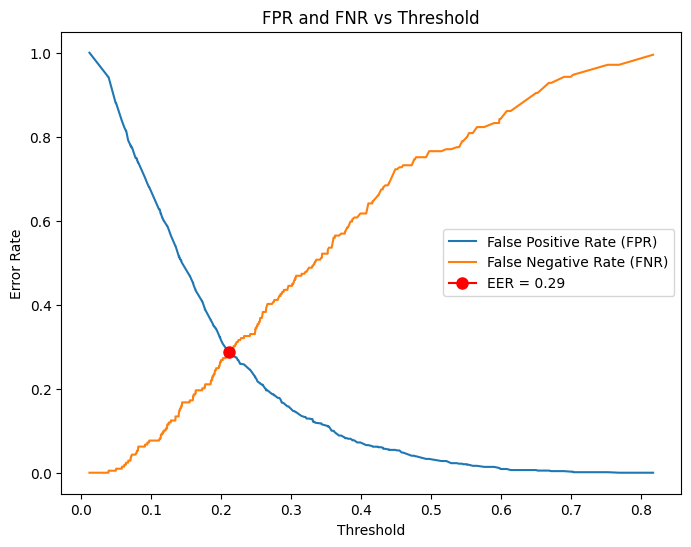

In [ ]:
# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# --- Calculate FNR ---
fnr = 1 - tpr

# --- Find the EER (Equal Error Rate) ---
eer_threshold = thresholds[np.argmin(np.abs(fpr - fnr))]
eer = fpr[np.argmin(np.abs(fpr - fnr))]

# --- Plot FPR and FNR vs threshold ---

plt.figure(figsize=(8, 6))
plt.plot(thresholds, fpr, label='False Positive Rate (FPR)')
plt.plot(thresholds, fnr, label='False Negative Rate (FNR)')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('FPR and FNR vs Threshold')

# Mark the EER point
plt.plot(eer_threshold, eer, marker='o', markersize=8, color="red", label=f'EER = {eer:.2f}')

plt.legend()
plt.show()

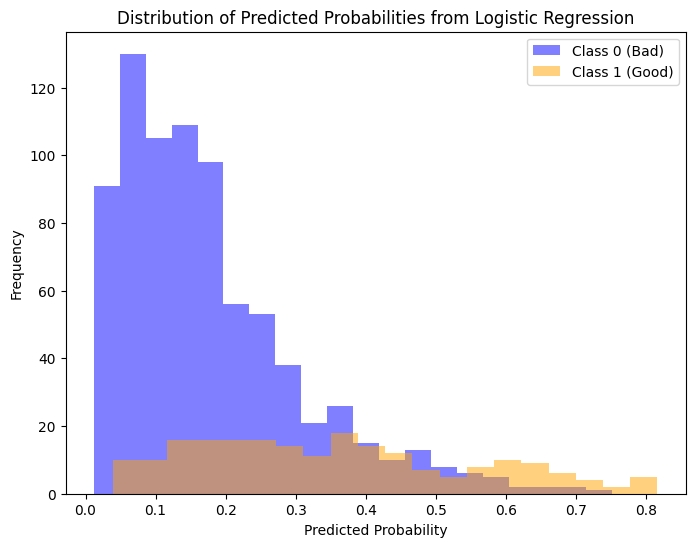

In [ ]:
# --- Plot the distribution of predicted probabilities ---

plt.figure(figsize=(8, 6))

# Plot for class 0 (bad quality)
plt.hist(y_proba[y_test == 0], bins=20, color='blue', alpha=0.5, label='Class 0 (Bad)')

# Plot for class 1 (good quality)
plt.hist(y_proba[y_test == 1], bins=20, color='orange', alpha=0.5, label='Class 1 (Good)')

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities from Logistic Regression')
plt.legend()
plt.show()

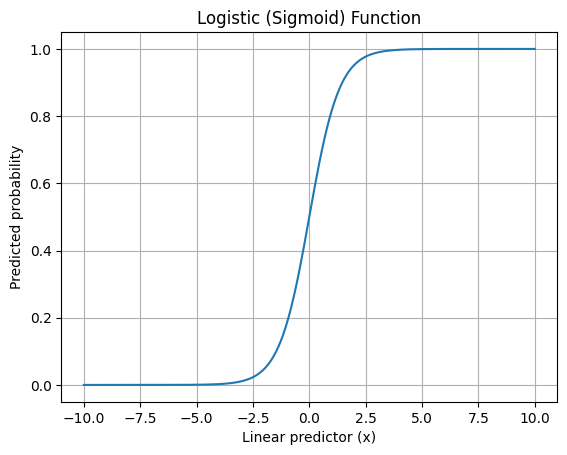

In [ ]:
# 8. Logistic (sigmoid) function – conceptual plot

# Generate input data (linear predictor z)
x = np.linspace(-10, 10, 200)
z = 1.5 * x  # Linear combination (z = beta_0 + beta_1 * x)

# Logistic (sigmoid) function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

p = sigmoid(z)

plt.figure()
plt.plot(x, p)
plt.xlabel("Linear predictor (x)")
plt.ylabel("Predicted probability")
plt.title("Logistic (Sigmoid) Function")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.show()


In [ ]:
# 9. Logistic Regression with polynomial numeric features (optional)

# For numeric features, we create degree-2 polynomial terms.
numeric_poly = Pipeline(
    steps=[
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler()),
    ]
)

preprocessor_poly = ColumnTransformer(
    transformers=[
        ("num", numeric_poly, numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ]
)

log_reg_poly = LogisticRegression(max_iter=1000)

poly_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor_poly),
        ("model", log_reg_poly),
    ]
)

poly_clf.fit(X_train, y_train)
print("Polynomial-feature Logistic Regression model trained.")

# Evaluate on test set
y_proba_poly = poly_clf.predict_proba(X_test)[:, 1]
y_pred_poly = (y_proba_poly >= 0.5).astype(int)

acc_poly = accuracy_score(y_test, y_pred_poly)
prec_poly = precision_score(y_test, y_pred_poly)
rec_poly = recall_score(y_test, y_pred_poly)
f1_poly = f1_score(y_test, y_pred_poly)
auc_poly = roc_auc_score(y_test, y_proba_poly)

print("Polynomial Logistic Regression performance (threshold = 0.5):")
print(f"  Accuracy : {acc_poly:.3f}")
print(f"  Precision: {prec_poly:.3f}")
print(f"  Recall   : {rec_poly:.3f}")
print(f"  F1-score : {f1_poly:.3f}")
print(f"  AUC      : {auc_poly:.3f}")


Polynomial-feature Logistic Regression model trained.
Polynomial Logistic Regression performance (threshold = 0.5):
  Accuracy : 0.869
  Precision: 0.825
  Recall   : 0.474
  F1-score : 0.602
  AUC      : 0.861
